# Acne Classification Pipeline
Step-by-step visual analysis using existing methods

In [51]:
# Imports
import sys
sys.path.append('.')
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import FileUpload, Button, VBox, Output
from IPython.display import display
import io

In [52]:
# Load existing components
from acne_classifier.model_loader import load_models
from acne_classifier.prediction import AcnePredictor
from acne_classifier.ingredient_recommendations import IngredientRecommender
from acne_classifier.product_search import ProductSearcher

print("Loading components...")
model, processor, face_app, model_config_dict = load_models()
predictor = AcnePredictor(model, processor, face_app, model_config_dict)
recommender = IngredientRecommender()
searcher = ProductSearcher()
print("✅ Ready!")

Loading components...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/vo/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/vo/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/vo/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/vo/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/vo/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 1

In [53]:
# Upload image - IMPROVED WITH BUTTON
uploader = FileUpload(accept='image/*', description='Upload Image')
process_button = Button(description='Process Image', button_style='success')
output_area = Output()

def on_button_click(b):
    with output_area:
        output_area.clear_output()
        try:
            # Check if file is uploaded - uploader.value is a tuple of file info dicts
            if uploader.value and len(uploader.value) > 0:
                # Get the first uploaded file from the tuple
                file_info = uploader.value[0]
                global image
                image = Image.open(io.BytesIO(file_info['content']))
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                
                plt.figure(figsize=(6, 6))
                plt.imshow(image)
                plt.title("Original Image")
                plt.axis('off')
                plt.show()
                print(f"✅ Image loaded successfully: {file_info['name']}")
                print("✅ You can now run the next cells to analyze the image.")
            else:
                print("❌ Please upload an image first (no files detected)")
        except Exception as e:
            print(f"❌ Error loading image: {e}")
            import traceback
            traceback.print_exc()

process_button.on_click(on_button_click)
display(VBox([uploader, process_button, output_area]))

🎯 Face Detection


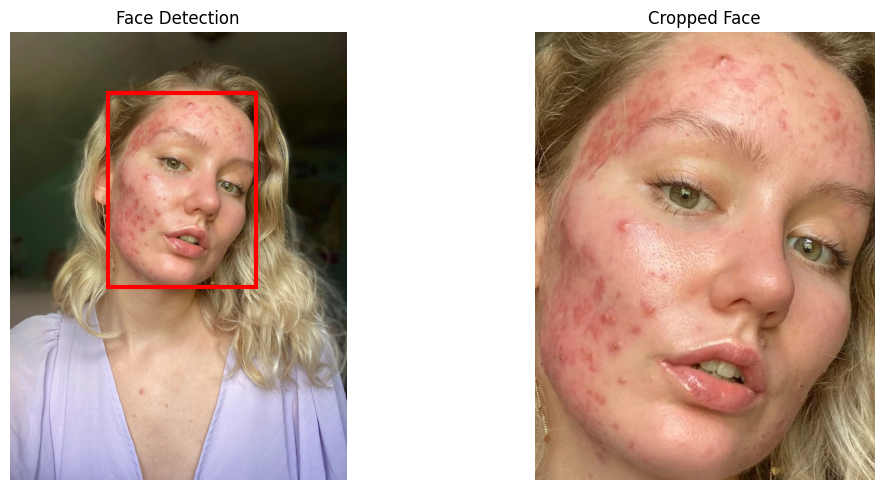

Face detected: 450,277 to 1124,1166


In [54]:
# Face Detection & Cropping
try:
    if 'image' in locals():
        print("🎯 Face Detection")
        img_array = np.array(image)
        faces = face_app.get(img_array)
        
        if faces:
            x1, y1, x2, y2 = faces[0].bbox.astype(int)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Original with face box
            ax1.imshow(img_array)
            ax1.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=3))
            ax1.set_title("Face Detection")
            ax1.axis('off')
            
            # Cropped face
            cropped = img_array[y1:y2, x1:x2]
            ax2.imshow(cropped)
            ax2.set_title("Cropped Face")
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
            print(f"Face detected: {x1},{y1} to {x2},{y2}")
        else:
            print("No face detected")
    else:
        print("Please upload an image first")
except Exception as e:
    print(f"Error in face detection: {e}")

🧠 Acne Classification
Prediction: level 3
Confidence: 0.454
Severity: severe


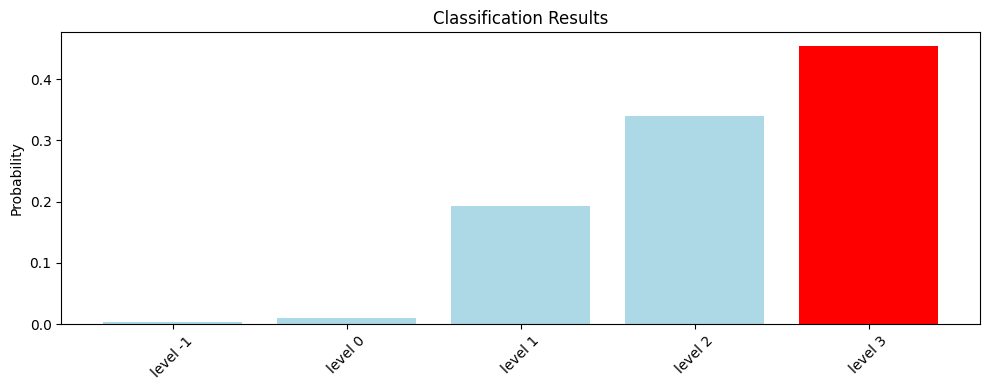

In [55]:
# Acne Classification
try:
    if 'image' in locals():
        print("🧠 Acne Classification")
        result = predictor.predict(image)
        
        if 'error' not in result:
            print(f"Prediction: {result['predicted_label']}")
            print(f"Confidence: {result['confidence']:.3f}")
            print(f"Severity: {result['severity']}")
            
            # Show probabilities
            classes = list(model_config_dict['id2label'].values())
            probs = result['probabilities']
            
            plt.figure(figsize=(10, 4))
            colors = ['red' if i == result['predicted_class_id'] else 'lightblue' for i in range(len(classes))]
            plt.bar(classes, probs, color=colors)
            plt.title('Classification Results')
            plt.ylabel('Probability')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Error: {result['error']}")
    else:
        print("Please upload an image first")
except Exception as e:
    print(f"Error in classification: {e}")

In [56]:
# AI Recommendations
try:
    if 'result' in locals() and 'error' not in result:
        print("🤖 AI Recommendations")
        
        recommendations = recommender.get_recommendations(result['predicted_label'])
        print("\nAI Response:")
        print(recommendations)
        
        parsed = recommender.parse_recommendations(recommendations)
        print("\nParsed ingredients:")
        for category, ingredients in parsed.items():
            print(f"{category}: {ingredients}")
    else:
        print("Please upload an image and run classification first")
except Exception as e:
    print(f"Error in recommendations: {e}")

OpenAI client not initialized


🤖 AI Recommendations

AI Response:
Error: OpenAI API key not configured

Parsed ingredients:
cleanser: []
moisturizer: []
exfoliator: []


In [ ]:
# Product Search
try:
    if 'parsed' in locals():
        print("🛍️ Product Search")
        
        products = searcher.search_all_categories(parsed)
        
        for category, items in products.items():
            print(f"\n{category.upper()}:")
            if items:
                for i, product in enumerate(items[:3], 1):
                    print(f"{i}. {product['product_name']}")
                    print(f"   Price: {product['price']}")
                    print(f"   Score: {product['combined_score']}")
            else:
                print("No products found")
    else:
        print("Please complete previous steps first")
except Exception as e:
    print(f"Error in product search: {e}")